# **CNBC BUSINESS AND FINANCE NEWS**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from collections import Counter
from nltk import download
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **Bước 1: Chuẩn bị dữ liệu**

Tổng quan các thuộc tính

Dựa vào năm dòng đầu tiên của tập dữ liệu, dữ liệu bao gồm các bài báo từ trang tin tức CNBC với các thuộc tính sau:

1. **title**: Tiêu đề của bài viết.
2. **url**: Đường link tới bài viết trên trang web.
3. **published_at**: Thời gian bài viết được công bố.
4. **author**: Tác giả của bài viết.
5. **publisher**: Nhà xuất bản của bài viết, trong trường hợp này là CNBC.
6. **short_description**: Mô tả ngắn gọn về bài viết.
7. **keywords**: Từ khóa liên quan đến bài viết.
8. **header_image**: Đường link tới hình ảnh đại diện của bài viết.
9. **raw_description**: Mô tả thô về bài viết, có thể bao gồm các thẻ HTML.
10. **description**: Mô tả về bài viết, có thể giống hoặc khác với "short_description".
11. **scraped_at**: Thời gian dữ liệu được thu thập.

Với bài phân tích này chúng ta sẽ tập trung vào 3 thuộc tính chính là `keywords`, `title` và `short_description`

In [ ]:
df_cnbc = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/data_analysis/DoAn/cnbc_news_datase.csv')
df_cnbc.head(5)

,title,url,published_at,author,publisher,short_description,keywords,header_image,raw_description,description,scraped_at
0,Santoli’s Wednesday market notes: Could Septem...,https://www.cnbc.com/2021/09/29/santolis-wedne...,2021-09-29T17:09:39+0000,Michael Santoli,CNBC,"This is the daily notebook of Mike Santoli, CN...","cnbc, Premium, Articles, Investment strategy, ...",https://image.cnbcfm.com/api/v1/image/10694960...,"<div class=""group""><p><em>This is the daily no...","This is the daily notebook of Mike Santoli, CN...",2021-10-30 14:11:23.709372
1,My take on the early Brexit winners and losers,https://www.cnbc.com/2016/06/24/ian-bremmers-t...,2016-06-24T13:50:48-0400,NaN,CNBC,This commentary originally ran on Facebook. Bo...,"Articles, Politics, Europe News, European Cent...",https://fm.cnbc.com/applications/cnbc.com/reso...,NaN,NaN,2021-10-30 14:11:23.820139
2,Europe&#039;s recovery depends on Renzi&#039;s...,https://www.cnbc.com/2014/03/25/europes-recove...,2014-03-25T13:29:45-0400,NaN,CNBC,"In spring, ambitious reforms began in Italy. U...","Articles, Business News, Economy, Europe Econo...",https://fm.cnbc.com/applications/cnbc.com/reso...,NaN,NaN,2021-10-30 14:11:23.854710
3,US Moves Closer to Becoming A Major Shareholde...,https://www.cnbc.com/2009/04/22/us-moves-close...,2009-04-22T19:49:03+0000,Michelle Caruso-Cabrera,CNBC,The US government is increasingly likely to co...,"cnbc, Articles, General Motors Co, Business Ne...",https://image.cnbcfm.com/api/v1/image/24947979...,"<div class=""group""><p>The US government is inc...",The US government is increasingly likely to co...,2021-10-30 14:11:24.261143
4,Trump: 'Mission accomplished' on 'perfectly ex...,https://www.cnbc.com/2018/04/14/trump-mission-...,2018-04-14T14:59:04+0000,Javier E. David,CNBC,NaN,"cnbc, Articles, George W. Bush, Vladimir Putin...",https://image.cnbcfm.com/api/v1/image/10513177...,"<div class=""group""></div>,<div class=""group""><...",President Donald Trump hailed the U.S.-led int...,2021-10-30 14:11:24.489490


In [ ]:
df = df_cnbc[['title', 'short_description', 'keywords']]
df.head()

,title,short_description,keywords
0,Santoli’s Wednesday market notes: Could Septem...,"This is the daily notebook of Mike Santoli, CN...","cnbc, Premium, Articles, Investment strategy, ..."
1,My take on the early Brexit winners and losers,This commentary originally ran on Facebook. Bo...,"Articles, Politics, Europe News, European Cent..."
2,Europe&#039;s recovery depends on Renzi&#039;s...,"In spring, ambitious reforms began in Italy. U...","Articles, Business News, Economy, Europe Econo..."
3,US Moves Closer to Becoming A Major Shareholde...,The US government is increasingly likely to co...,"cnbc, Articles, General Motors Co, Business Ne..."
4,Trump: 'Mission accomplished' on 'perfectly ex...,NaN,"cnbc, Articles, George W. Bush, Vladimir Putin..."


In [ ]:
df.to_csv('/content/drive/MyDrive/Colab_Notebooks/data_analysis/DoAn/DoAnChinhThuc/cnbc_data.csv')

## **Bước 2: Xử lý dữ liệu**

In [ ]:
df.isnull().sum()

title                 0
short_description    16
keywords              0
dtype: int64

In [ ]:
df.dropna(inplace=True)
df.isnull().sum()

title                0
short_description    0
keywords             0
dtype: int64

In [ ]:
df.columns

Index(['title', 'short_description', 'keywords'], dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 609 entries, 0 to 624
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title              609 non-null    object
 1   short_description  609 non-null    object
 2   keywords           609 non-null    object
dtypes: object(3)
memory usage: 19.0+ KB


## **Bước 3: Làm sạch dữ liệu**

### **3.1 : Kiểm tra và xử lý chuỗi (symbol, stopword, punctuations)**

Xem và xuất ra tổng quát các cột cần kiểm tra

In [ ]:
df['title'].unique()

array(['Santoli’s Wednesday market notes: Could September’s stock shakeout tee up strength for the fourth quarter?',
       'My take on the early Brexit winners and losers',
       'Europe&#039;s recovery depends on Renzi&#039;s Italy',
       'US Moves Closer to Becoming A Major Shareholder In GM',
       'Chevron CEO Watson says he supports Trump on tax reform',
       '22. Hexadite',
       'European stocks close higher on supportive Fed; Signature Aviation skyrockets 40%',
       "Fewer investors have a 'fear of missing out,' so it may be time to buckle up, market bull suggests",
       'Morgan Stanley Tries to Stave Off Ratings Cut ',
       "Consultant to 'Vampire Squid of Expert Network Firms' Questioned by FBI",
       'Average tax refunds are down 8.4% in the wake of Trump tax cuts',
       "Watch: Oaktree Capital's Howard Marks speak from the Context Summit",
       'Guggenheim says solar sell-off is a buying opportunity and has an unusual favorite stock',
       'Eni Pays Do

In [ ]:
df['short_description'].unique()

array(["This is the daily notebook of Mike Santoli, CNBC's senior markets commentator, with ideas about trends, stocks and market statistics.",
       'This commentary originally ran on Facebook. Boris Johnson – The former London mayor and grudging "Leave" supporter-turned enthusiastic "Leave" leader chose the winning side. He\'s now a front-runner to lead the Tory party. \u202a#\u200eHellFreezesOver\u202c Theresa May – Boris Johnson\'s populist approach to the Brexit campaign ticked off quite a few Tory elders, so the real money should be on UK Home Secretary Theresa May to succeed outgoing Prime Minister David Cameron. May is a political heavyweight and is generally respected among the Tories, something Boris Johnson is … um, not.  Nigel Farage – the once-embattled UK Independence Party leader gets his moment in the sun. Also gets to keep having a political career. And the fact that he quoted "Independence Day" in his victory speech made a crazy night that much crazier.  Marine Le Pe

In [ ]:
df['keywords'].unique()

array(['cnbc, Premium, Articles, Investment strategy, Markets, Investing, PRO Home, CNBC Pro, Pro: Santoli on Stocks, source:tagname:CNBC US Source',
       'Articles, Politics, Europe News, European Central Bank, S&P 500 Index, U.S. Markets, Commentary, Brexit, US Economy, stocks, Wall Street, World Economy, Markets',
       'Articles, Business News, Economy, Europe Economy, Employment, Commentary, Politics, source:tagname:CNBC US Source',
       'cnbc, Articles, General Motors Co, Business News, Transportation, Autos, source:tagname:CNBC US Source',
       'cnbc, Articles, White House, Oil and Gas, Chevron Corp, Donald Trump, Business, Exxon Mobil Corp, Business News, Closing Bell, source:tagname:CNBC US Source',
       'Articles, Technology, CNBC Upstart 2018, Boston, Special Reports, Crime, Hardware, Start-ups, Cybersecurity, CNBC Upstart, source:tagname:CNBC US Source',
       'cnbc, Articles, World economy, World Markets, FTSE MIB, CAC 40 Index, DAX, FTSE 100, Jerome Powell, Unit

Lặp qua và in ra các mô tả ngắn



In [ ]:
for index,text in enumerate(df['title'][35:40]):
  print('Title %d:\n'%(index+1),text)

Title 1:
 China to Rein in Bank Lending, Ballooning Surplus
Title 2:
 Halftime Report: Watch Goldman Action Closely Into Close
Title 3:
 Porn and the Condom Conundrum 
Title 4:
 Stocks making the biggest moves midday: Activision, Snap, Ford & more
Title 5:
 All Eyes on Europe


In [ ]:
for index,text in enumerate(df['short_description'][35:40]):
  print('Short description %d:\n'%(index+1),text)

Short description 1:
 China will take steps to contain a renewed burst in bank lending and a larger-than-expected rise in the country's controversial trade surplus last month, senior officials said on Friday. Speaking on the sidelines of a annual parliamentary session, which ends on Friday, central bank governor Zhou Xiaochuan said the authorities would place further controls on bank lending."From a commercial perspective, it is understandable for the banks to lend aggressively at the beginning of the year," Zhou told reporters. "But from a macro perspective, after serious study, we decided to place further controls (on it)," he said. He did not offer any timeframe. Lending data released this week reinforced concern that banks, awash with cash, may fund a new round of speculative investment. Lending surged by 413.8 billion yuan in February, compared with an increase of 149.1 billion yuan in February 2006. Separately, Commerce Minister Bo Xilai said the nation's trade surplus had been "

### **3.2 : Xử lý các dạng từ. (Expand contractions, Lowercase the reviews, Remove digits and words containing digits, Remove punctuations)**

Expand Contractions

In [ ]:
import re

contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not",
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

df['title'] = df['title'].apply(lambda x:expand_contractions(x))
df['short_description'] = df['short_description'].apply(lambda x:expand_contractions(x))

Chuẩn hóa chữ thường (Lowercase)

In [ ]:
df['cleaned_title']=df['title'].apply(lambda x: x.lower())
df['cleaned_shdesc']=df['short_description'].apply(lambda x: x.lower())

Loại bỏ số và từ chứa số (Remove digits and words containing digits)

In [ ]:
df['cleaned_title']=df['cleaned_title'].apply(lambda x: re.sub('\w*\d\w*','', x))
df['cleaned_shdesc']=df['cleaned_shdesc'].apply(lambda x: re.sub('\w*\d\w*','', x))

Remove Punctuations

In [ ]:
import string

df['cleaned_title']=df['cleaned_title'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
df['cleaned_shdesc']=df['cleaned_shdesc'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [ ]:
df['cleaned_title']=df['cleaned_title'].apply(lambda x: re.sub(' +',' ',x))
df['cleaned_shdesc']=df['cleaned_shdesc'].apply(lambda x: re.sub(' +',' ',x))

In [ ]:
for index,text in enumerate(df['cleaned_title'][35:40]):
  print('Title %d:\n'%(index+1),text)

Title 1:
 china to rein in bank lending ballooning surplus
Title 2:
 halftime report watch goldman action closely into close
Title 3:
 porn and the condom conundrum 
Title 4:
 stocks making the biggest moves midday activision snap ford more
Title 5:
 all eyes on europe


In [ ]:
for index,text in enumerate(df['cleaned_shdesc'][35:40]):
  print('Short description %d:\n'%(index+1),text)

Short description 1:
 china will take steps to contain a renewed burst in bank lending and a largerthanexpected rise in the country is controversial trade surplus last month senior officials said on friday speaking on the sidelines of a annual parliamentary session which ends on friday central bank governor zhou xiaochuan said the authorities would place further controls on bank lendingfrom a commercial perspective it is understandable for the banks to lend aggressively at the beginning of the year zhou told reporters but from a macro perspective after serious study we decided to place further controls on it he said he did not offer any timeframe lending data released this week reinforced concern that banks awash with cash may fund a new round of speculative investment lending surged by billion yuan in february compared with an increase of billion yuan in february separately commerce minister bo xilai said the nation is trade surplus had been too large in february and reaffirmed that b

In [ ]:
df.head()

,title,short_description,keywords,cleaned_title,cleaned_shdesc
0,Santoli’s Wednesday market notes: Could Septem...,"This is the daily notebook of Mike Santoli, CN...","cnbc, Premium, Articles, Investment strategy, ...",santoli’s wednesday market notes could septemb...,this is the daily notebook of mike santoli cnb...
1,My take on the early Brexit winners and losers,This commentary originally ran on Facebook. Bo...,"Articles, Politics, Europe News, European Cent...",my take on the early brexit winners and losers,this commentary originally ran on facebook bor...
2,Europe&#039;s recovery depends on Renzi&#039;s...,"In spring, ambitious reforms began in Italy. U...","Articles, Business News, Economy, Europe Econo...",europes recovery depends on renzis italy,in spring ambitious reforms began in italy und...
3,US Moves Closer to Becoming A Major Shareholde...,The US government is increasingly likely to co...,"cnbc, Articles, General Motors Co, Business Ne...",us moves closer to becoming a major shareholde...,the us government is increasingly likely to co...
5,Chevron CEO Watson says he supports Trump on t...,Chevron Chief Executive John Watson told CNBC ...,"cnbc, Articles, White House, Oil and Gas, Chev...",chevron ceo watson says he supports trump on t...,chevron chief executive john watson told cnbc ...


In [ ]:
df.to_csv('/content/drive/MyDrive/Colab_Notebooks/data_analysis/DoAn/DoAnChinhThuc/cnbc_data_new.csv')

## **Bước 4: Xử lý stopword và lemmatization (Document Term Matrix)**

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

df['lemmatized_title']=df['cleaned_title'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))
df['lemmatized_shdesc']=df['cleaned_shdesc'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

In [ ]:
df_grouped=df[['title','lemmatized_title', 'short_description', 'lemmatized_shdesc']].groupby(by='title').agg(lambda x:' '.join(x))
df_grouped.head()

,lemmatized_title,short_description,lemmatized_shdesc
title,,,
"25 highest-paid hedge fund managers made $32 billion in 2020, a record",highestpaid hedge fund manager billion record,The 25 highest-paid hedge fund managers made a...,highestpaid hedge fund manager record billion ...
Did EA Bust the Social Gaming Bubble?,ea bust social gaming bubble,When Electronic Arts bought social games maker...,electronic art buy social game maker playfish ...
Is the Fed Prepping Markets for the End of QE?,fed preppe market end qe,If an article in Monday is Wall Street Journal...,article monday wall street journal federal res...
"""Bussiness Nation"" Will Air On April 18th",bussiness nation air april,"A repeat of CNBC is ""Business Nation"" will air...",repeat cnbc business nation air wednesday apri...
$2B has piled into this group of stocks in 2016,pile group stock,One of the hottest trades of the year is about...,hot trade year hot mining stock strike gold st...


In [ ]:
df_cleaned = df.copy()

## **Bước 5: Khám phá dữ liệu**

* Sử dụng N - Gram

* Sử dụng Word Cloud

* Sử dụng K - Means

In [ ]:
df_cleaned.head()

,title,short_description,keywords,cleaned_title,cleaned_shdesc,lemmatized_title,lemmatized_shdesc
0,Santoli’s Wednesday market notes: Could Septem...,"This is the daily notebook of Mike Santoli, CN...","cnbc, Premium, Articles, Investment strategy, ...",santoli’s wednesday market notes could septemb...,this is the daily notebook of mike santoli cnb...,santoli wednesday market note september stock ...,daily notebook mike santoli cnbc senior market...
1,My take on the early Brexit winners and losers,This commentary originally ran on Facebook. Bo...,"Articles, Politics, Europe News, European Cent...",my take on the early brexit winners and losers,this commentary originally ran on facebook bor...,early brexit winner loser,commentary originally run facebook boris johns...
2,Europe&#039;s recovery depends on Renzi&#039;s...,"In spring, ambitious reforms began in Italy. U...","Articles, Business News, Economy, Europe Econo...",europes recovery depends on renzis italy,in spring ambitious reforms began in italy und...,europe recovery depend renzi italy,spring ambitious reform begin italy matteo ren...
3,US Moves Closer to Becoming A Major Shareholde...,The US government is increasingly likely to co...,"cnbc, Articles, General Motors Co, Business Ne...",us moves closer to becoming a major shareholde...,the us government is increasingly likely to co...,move close major shareholder gm,government increasingly likely convert billion...
5,Chevron CEO Watson says he supports Trump on t...,Chevron Chief Executive John Watson told CNBC ...,"cnbc, Articles, White House, Oil and Gas, Chev...",chevron ceo watson says he supports trump on t...,chevron chief executive john watson told cnbc ...,chevron ceo watson say support trump tax reform,chevron chief executive john watson tell cnbc ...


### 5.1: Xử lý dữ liệu `short_description`

In [ ]:
def tokenize(column):
    tokens = word_tokenize(column)
    return [w for w in tokens if w.isalpha()]

df_cleaned['cleaned_token'] = df_cleaned.apply(lambda x: tokenize(x['cleaned_shdesc']), axis=1)
df_cleaned.head()

,title,short_description,keywords,cleaned_title,cleaned_shdesc,lemmatized_title,lemmatized_shdesc,cleaned_token
0,Santoli’s Wednesday market notes: Could Septem...,"This is the daily notebook of Mike Santoli, CN...","cnbc, Premium, Articles, Investment strategy, ...",santoli’s wednesday market notes could septemb...,this is the daily notebook of mike santoli cnb...,santoli wednesday market note september stock ...,daily notebook mike santoli cnbc senior market...,"[this, is, the, daily, notebook, of, mike, san..."
1,My take on the early Brexit winners and losers,This commentary originally ran on Facebook. Bo...,"Articles, Politics, Europe News, European Cent...",my take on the early brexit winners and losers,this commentary originally ran on facebook bor...,early brexit winner loser,commentary originally run facebook boris johns...,"[this, commentary, originally, ran, on, facebo..."
2,Europe&#039;s recovery depends on Renzi&#039;s...,"In spring, ambitious reforms began in Italy. U...","Articles, Business News, Economy, Europe Econo...",europes recovery depends on renzis italy,in spring ambitious reforms began in italy und...,europe recovery depend renzi italy,spring ambitious reform begin italy matteo ren...,"[in, spring, ambitious, reforms, began, in, it..."
3,US Moves Closer to Becoming A Major Shareholde...,The US government is increasingly likely to co...,"cnbc, Articles, General Motors Co, Business Ne...",us moves closer to becoming a major shareholde...,the us government is increasingly likely to co...,move close major shareholder gm,government increasingly likely convert billion...,"[the, us, government, is, increasingly, likely..."
5,Chevron CEO Watson says he supports Trump on t...,Chevron Chief Executive John Watson told CNBC ...,"cnbc, Articles, White House, Oil and Gas, Chev...",chevron ceo watson says he supports trump on t...,chevron chief executive john watson told cnbc ...,chevron ceo watson say support trump tax reform,chevron chief executive john watson tell cnbc ...,"[chevron, chief, executive, john, watson, told..."


In [ ]:
def extract_ngrams(tokenized_data,n):
    ngrams_list = list(nltk.ngrams(tokenized_data, n))
    ngrams_str = [' '.join(grams) for grams in ngrams_list]
    return ngrams_str

df_cleaned['cleaned_token'] = df_cleaned['cleaned_token'].apply(lambda x: extract_ngrams(x, 2))
df_cleaned.head()

,title,short_description,keywords,cleaned_title,cleaned_shdesc,lemmatized_title,lemmatized_shdesc,cleaned_token
0,Santoli’s Wednesday market notes: Could Septem...,"This is the daily notebook of Mike Santoli, CN...","cnbc, Premium, Articles, Investment strategy, ...",santoli’s wednesday market notes could septemb...,this is the daily notebook of mike santoli cnb...,santoli wednesday market note september stock ...,daily notebook mike santoli cnbc senior market...,"[this is, is the, the daily, daily notebook, n..."
1,My take on the early Brexit winners and losers,This commentary originally ran on Facebook. Bo...,"Articles, Politics, Europe News, European Cent...",my take on the early brexit winners and losers,this commentary originally ran on facebook bor...,early brexit winner loser,commentary originally run facebook boris johns...,"[this commentary, commentary originally, origi..."
2,Europe&#039;s recovery depends on Renzi&#039;s...,"In spring, ambitious reforms began in Italy. U...","Articles, Business News, Economy, Europe Econo...",europes recovery depends on renzis italy,in spring ambitious reforms began in italy und...,europe recovery depend renzi italy,spring ambitious reform begin italy matteo ren...,"[in spring, spring ambitious, ambitious reform..."
3,US Moves Closer to Becoming A Major Shareholde...,The US government is increasingly likely to co...,"cnbc, Articles, General Motors Co, Business Ne...",us moves closer to becoming a major shareholde...,the us government is increasingly likely to co...,move close major shareholder gm,government increasingly likely convert billion...,"[the us, us government, government is, is incr..."
5,Chevron CEO Watson says he supports Trump on t...,Chevron Chief Executive John Watson told CNBC ...,"cnbc, Articles, White House, Oil and Gas, Chev...",chevron ceo watson says he supports trump on t...,chevron chief executive john watson told cnbc ...,chevron ceo watson say support trump tax reform,chevron chief executive john watson tell cnbc ...,"[chevron chief, chief executive, executive joh..."


In [ ]:
def combine_words(word_list):
    all_words = []
    for word in word_list: all_words += word
    return all_words

def count_topwords(all_words):
    counts = dict()
    for word in all_words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
    word_count = pd.DataFrame([counts])
    word_count_transposed = word_count.T.reset_index()
    word_count_transposed.columns = ['words','word_count']
    word_count_sorted = word_count_transposed.sort_values("word_count",ascending =False)
    word_count_sorted
    return word_count_sorted[:10]

title = df_cleaned['cleaned_token']
title_words = combine_words(title)
title_words[:10]

['this is',
 'is the',
 'the daily',
 'daily notebook',
 'notebook of',
 'of mike',
 'mike santoli',
 'santoli cnbc',
 'cnbc is',
 'is senior']

In [ ]:
title_topword_count = count_topwords(title_words)
title_topword_count.head()

,words,word_count
241,of the,825
115,in the,770
59,to the,345
341,on the,343
1018,it is,337


Sử dụng K - Means để phân cụm và tính toán chỉ số Silhoutte Score

For n_clusters = 2, the silhouette score is : 0.026583881532092995
For n_clusters = 4, the silhouette score is : 0.030970496292193974
For n_clusters = 6, the silhouette score is : 0.03935888155252349
For n_clusters = 8, the silhouette score is : 0.041287771745923074
For n_clusters = 10, the silhouette score is : 0.05154062179401671


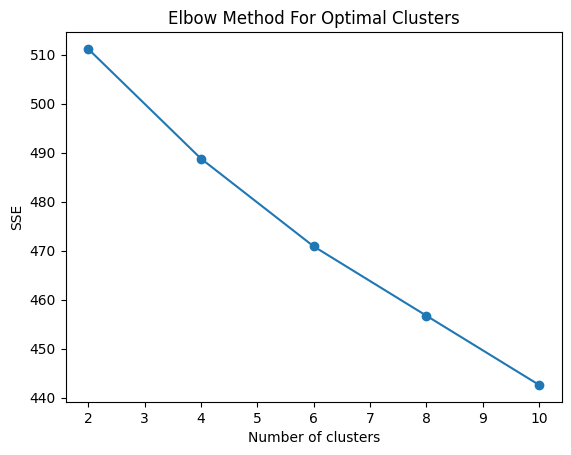

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
matrix = vectorizer.fit_transform(df_cleaned['lemmatized_shdesc'])

def find_optimal_clusters(data, max_k, random_state= 30):
    iters = range(2, max_k+1, 2)
    sse = []
    silhouette_scores = []

    for k in iters:
        model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=10, random_state=random_state)
        cluster_labels = model.fit_predict(data)
        sse.append(model.inertia_)

        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"For n_clusters = {k}, the silhouette score is : {silhouette_avg}")

    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('SSE')
    ax.set_title('Elbow Method For Optimal Clusters')
    plt.show()

find_optimal_clusters(matrix, 10, random_state= 30)

In [ ]:
kmeans_model = KMeans(n_clusters=5, init='k-means++', max_iter=100, n_init=10, random_state=30)
kmeans_model.fit(matrix)

clusters = kmeans_model.labels_
df_cleaned['cluster'] = clusters

print("Số lượng dữ liệu trong mỗi cụm:")
for i in range(5):
    print(f"Cụm {i}: {sum(df_cleaned['cluster'] == i)}")

print("\n10 từ hàng đầu trong mỗi cụm:")

order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]

terms = vectorizer.get_feature_names_out()
top_ten_words = {}

for i in range(num_clusters):
        print(f"Cluster {i}:", end='')
        top_ten_words[i] = [terms[ind] for ind in order_centroids[i, :10]]
        print(f"{top_ten_words[i]}")

Số lượng dữ liệu trong mỗi cụm:
Cụm 0: 93
Cụm 1: 78
Cụm 2: 105
Cụm 3: 77
Cụm 4: 256

10 từ hàng đầu trong mỗi cụm:
Cluster 0:['company', 'share', 'say', 'billion', 'revenue', 'business', 'ceo', 'year', 'million', 'stock']
Cluster 1:['stock', 'market', 'say', 'investor', 'buy', 'high', 'trade', 'company', 'like', 'week']
Cluster 2:['say', 'trump', 'president', 'state', 'people', 'new', 'tell', 'work', 'cnbc', 'million']
Cluster 3:['percent', 'rise', 'year', 'rate', 'say', 'fall', 'accord', 'growth', 'price', 'high']
Cluster 4:['say', 'bank', 'market', 'year', 'new', 'think', 'world', 'oil', 'like', 'million']


Word cloud

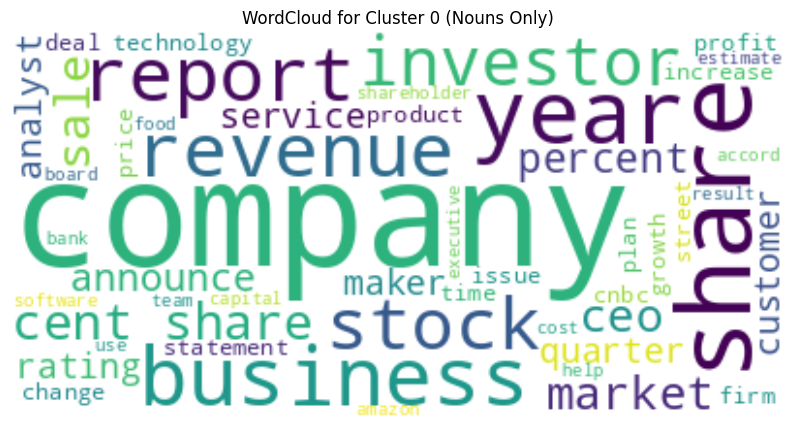

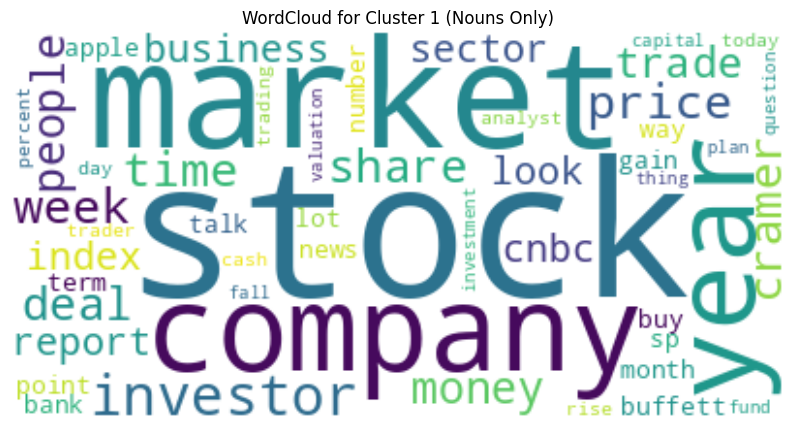

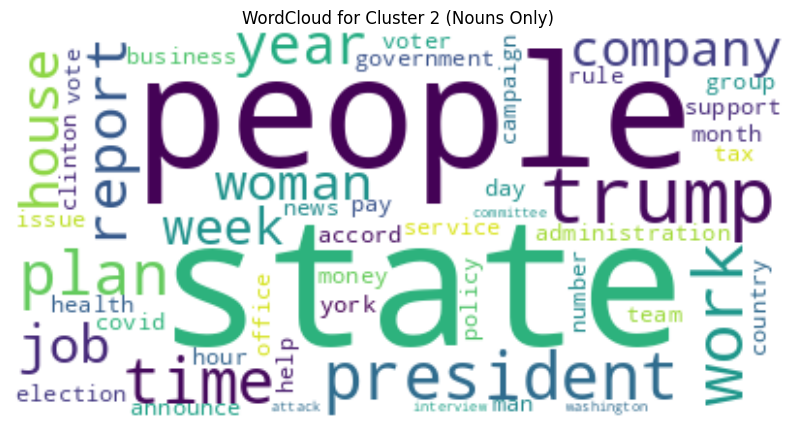

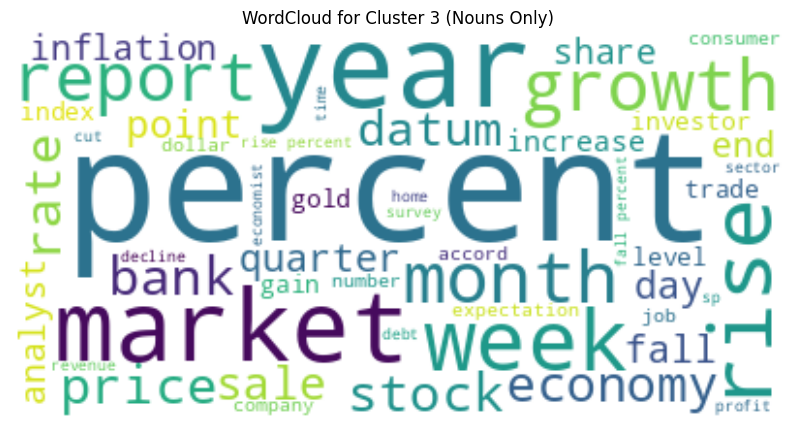

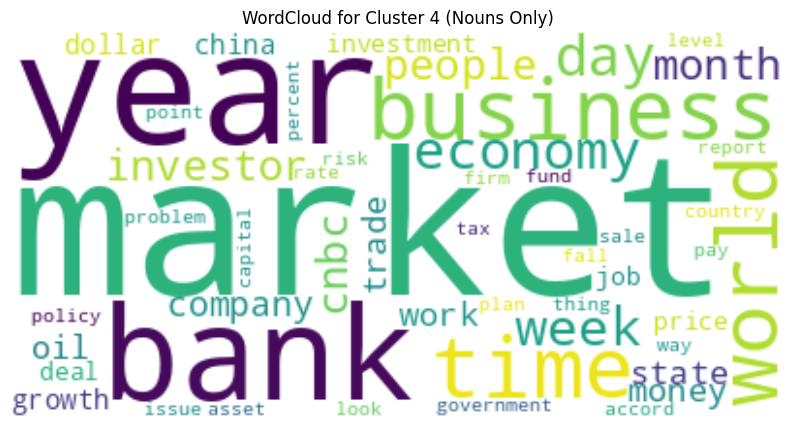

In [ ]:
def filter_nouns(text):
    words = word_tokenize(text)
    words_pos = pos_tag(words)
    nouns = [word for word, pos in words_pos if pos.startswith('NN')]
    return ' '.join(nouns)

def create_wordcloud_for_cluster_nouns(cluster_id):
    cluster_texts = df_cleaned[df_cleaned['cluster'] == cluster_id]['lemmatized_shdesc'].values
    all_texts = " ".join(cluster_texts).lower()
    all_texts = re.sub(r'[^a-zA-Z\s]', '', all_texts)
    nouns_text = filter_nouns(all_texts)

    wordcloud = WordCloud(stopwords=set(stopwords.words('english')),
                          background_color='white', max_words=50,
                          random_state= 30).generate(nouns_text)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud for Cluster {cluster_id} (Nouns Only)")
    plt.show()

for i in range(5):
    create_wordcloud_for_cluster_nouns(i)

Vẽ biểu đồ thể hiện tần suất xuất hiện của các danh từ của từng cụm

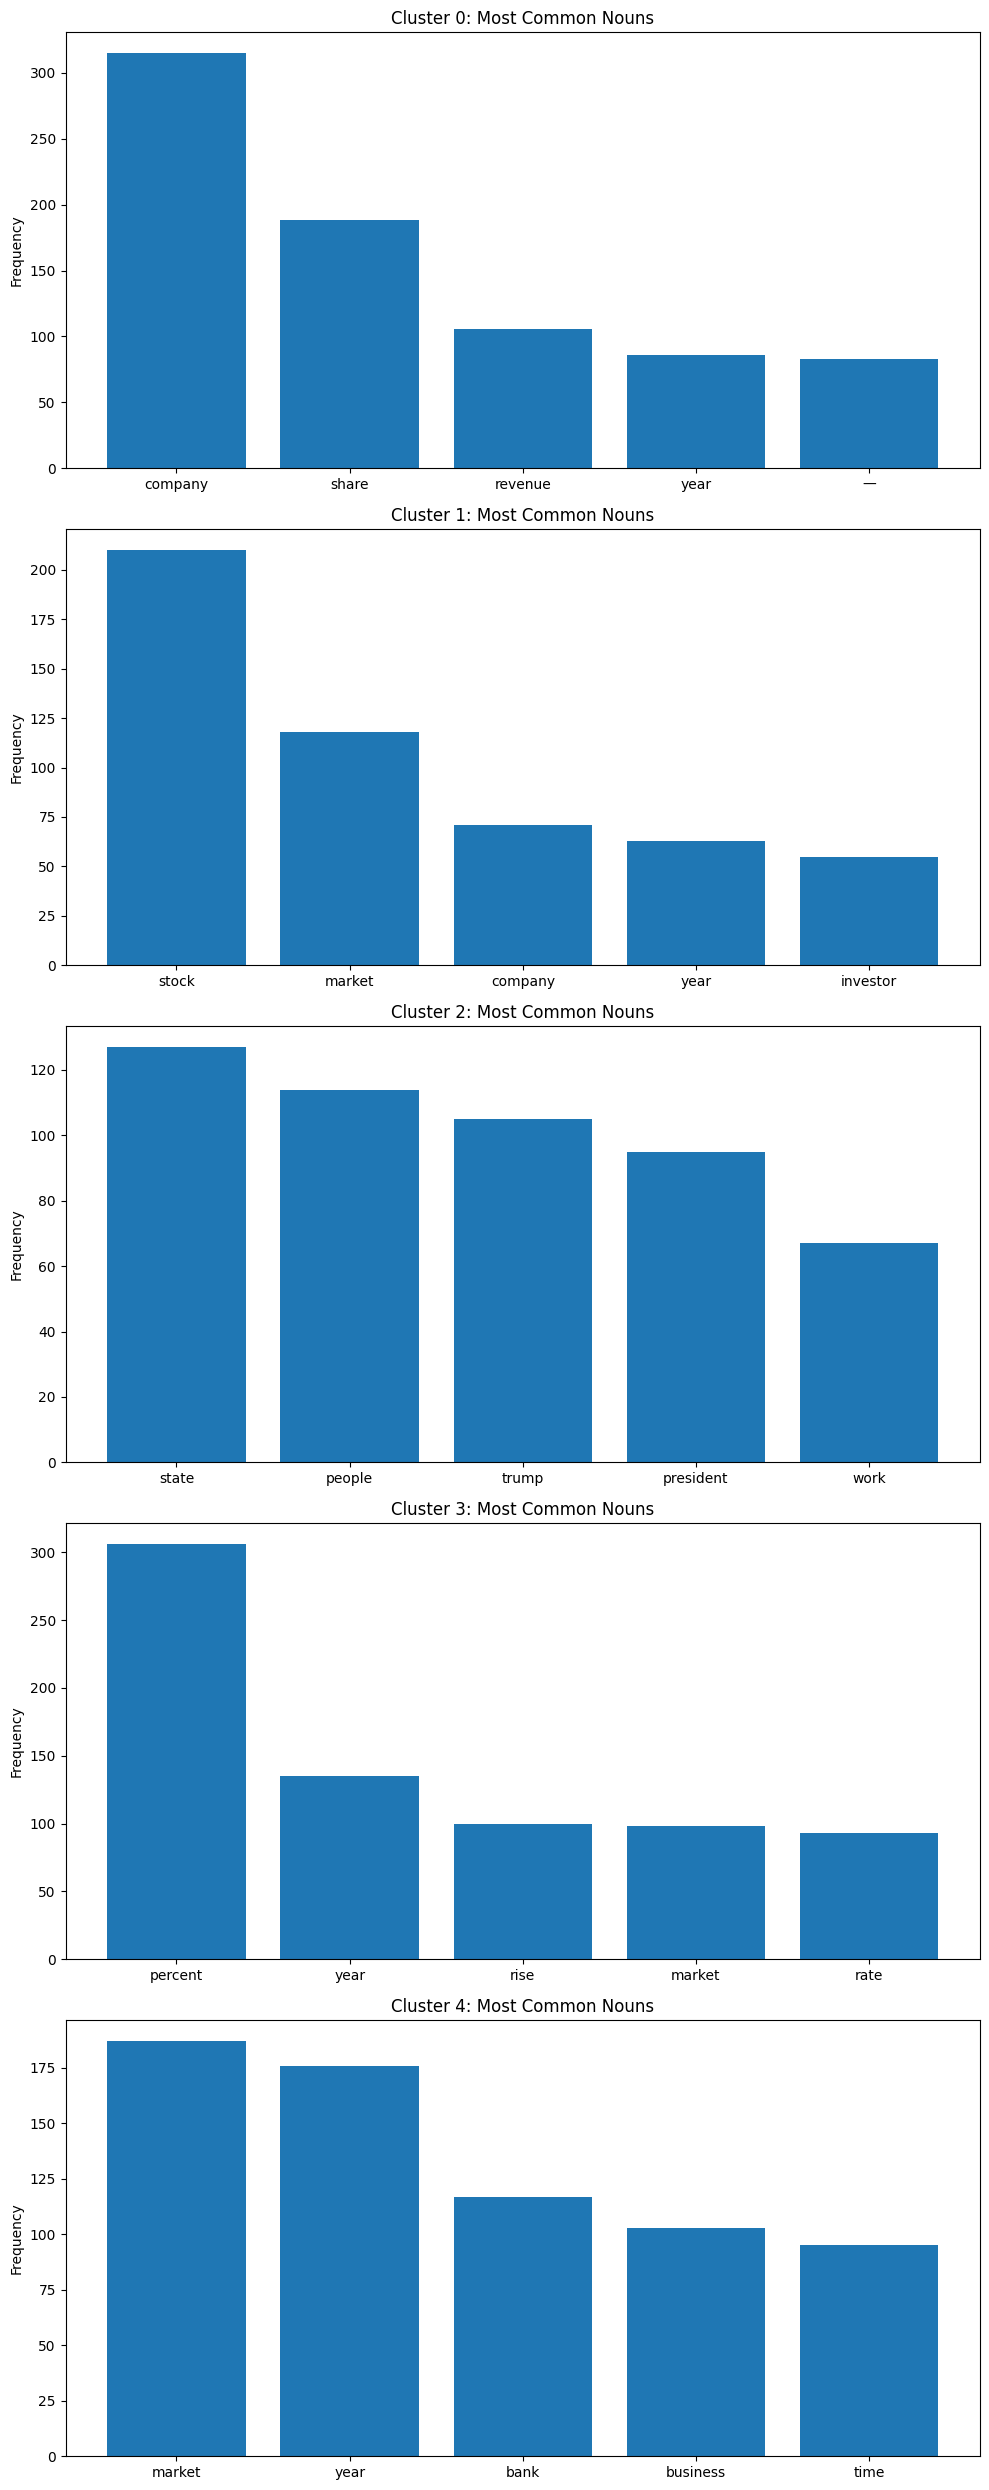

In [ ]:
def find_common_nouns(cluster_data, num_nouns=5):
    stopwords_english = set(stopwords.words('english'))
    all_nouns = []

    for description in cluster_data:
        tokens = word_tokenize(description.lower())
        pos_tags = pos_tag(tokens)
        nouns = [word for word, tag in pos_tags if tag.startswith('NN') and word not in stopwords_english]
        all_nouns.extend(nouns)

    most_common_nouns = Counter(all_nouns).most_common(num_nouns)
    return most_common_nouns

num_clusters = df_cleaned['cluster'].nunique()

plt.figure(figsize=(10, num_clusters * 5))

for cluster in range(num_clusters):
    plt.subplot(num_clusters, 1, cluster + 1)

    cluster_data = df_cleaned[df_cleaned['cluster'] == cluster]['lemmatized_shdesc']
    common_nouns = find_common_nouns(cluster_data)
    nouns, frequencies = zip(*common_nouns)

    plt.bar(nouns, frequencies)
    plt.title(f'Cluster {cluster}: Most Common Nouns')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Nhận xét

1. Từ biểu đồ Elbow và các chỉ số của Silhoutte score, ta nhận thấy được:

  * Biểu đồ Elbow: SSE giảm nhanh từ 2 cụm đến 4 cụm và sau đó chậm lại từ 5 cụm trở lên. Không có điểm Elbow rõ ràng (điểm gãy xảy ra ở đoạn 4 và 5)

  => Có thể chọn 4 hoặc 5 cụm.

  * Giá trị Silhouette Score: điểm số silhouette tăng liên tục theo số lượng cụm từ 2 đến 10. Tuy nhiên, sự tăng này không đáng kể.

2. Thông qua việc phân cụm thuộc tính `short_description`, có những điểm đáng lưu ý sau:

  * Cụm 4 chứa nhiều dữ liệu nhất (256 dữ liệu).

  * Với các từ khóa như **say, bank, market, year, new, think, world, oil, like, million** thể hiện các chủ đề liên quan đến tình hình kinh tế và tài chính toàn cầu, bao gồm cả ngành năng lượng như dầu mỏ.

  => Cho thấy được sự quan tâm và nhu cầu thông tin trong các lĩnh vực có ảnh hưởng rộng rãi đến kinh tế và đời sống xã hội.

### 5.2: Xử lý dữ liệu `title`


In [ ]:
def extract_nouns(text):
    words = word_tokenize(text)
    words = [word for word in words if word.isalpha()]
    words = [word for word in words if not word in stop_words]

    tagged = nltk.pos_tag(words)
    nouns = [word for word, tag in tagged if tag in ["NN", "NNS", "NNP", "NNPS"]]
    return nouns

nouns_list = [noun for title in df['cleaned_title'] for noun in extract_nouns(title)]

noun_counts = Counter(nouns_list)
most_common_nouns = noun_counts.most_common(20)

print("20 danh từ phổ biến nhất trong các title:")
for noun, count in most_common_nouns:
    print(f"{noun}: {count} lần")

20 danh từ phổ biến nhất trong các title:
stocks: 35 lần
market: 26 lần
trump: 20 lần
earnings: 17 lần
investors: 15 lần
oil: 15 lần
stock: 13 lần
china: 13 lần
trade: 12 lần
cramer: 11 lần
ceo: 10 lần
bank: 10 lần
report: 10 lần
house: 10 lần
apple: 9 lần
jobs: 9 lần
deal: 9 lần
dollar: 9 lần
markets: 9 lần
tax: 8 lần


Phân cụm dữ liệu `title`

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df_cleaned['lemmatized_title'])

kmeans = KMeans(n_clusters=5, random_state= 30)
kmeans.fit(X)
df_cleaned['cluster'] = kmeans.labels_

for i in range(5):
    print(f"Cụm {i}: {sum(df_cleaned['cluster'] == i)} dữ liệu")

Cụm 0: 15 dữ liệu
Cụm 1: 16 dữ liệu
Cụm 2: 512 dữ liệu
Cụm 3: 25 dữ liệu
Cụm 4: 41 dữ liệu


In [ ]:
titles = df_cleaned['lemmatized_title'].dropna().astype(str).tolist()

tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english', use_idf=True)
tfidf_matrix = tfidf_vectorizer.fit_transform(titles)

# Phân cụm sử dụng KMeans
num_clusters = 5
km = KMeans(n_clusters=num_clusters, n_init= 10, random_state=30)
km.fit(tfidf_matrix)
clusters = km.labels_

# Phân tích và in ra 10 từ hàng đầu trong mỗi cụm
terms = tfidf_vectorizer.get_feature_names_out()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

for i in range(num_clusters):
    print(f"Cụm {i}:", end='[')
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(', '.join(top_terms) + ']')

Cụm 0:[cnbc, live, air, february, night, april, change, today, tuesday, program]
Cụm 1:[market, bull, stock, strategist, fed, research, rally, impact, continue, end]
Cụm 2:[report, close, halftime, stock, earning, european, major, goldman, point, dow]
Cụm 3:[say, death, ceo, sudden, new, investor, million, oil, email, pm]
Cụm 4:[stock, china, new, trump, big, bank, ceo, amazon, investor, europe]


Word Cloud

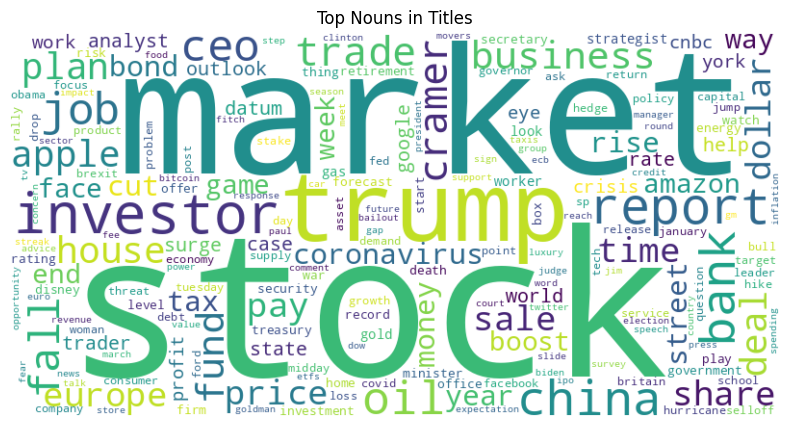

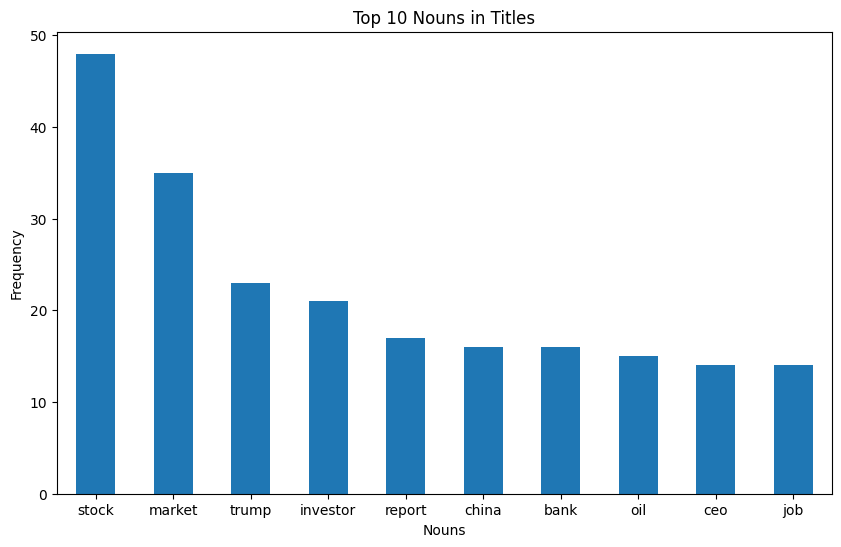

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from wordcloud import WordCloud

def filter_nouns(text):
    tokens = word_tokenize(text)
    words = [word for word in tokens if word.isalpha()]
    stopwords_english = set(stopwords.words('english'))
    words_clean = [word for word in words if word not in stopwords_english]
    tagged = nltk.pos_tag(words_clean)
    nouns = [word for word, pos in tagged if pos in ['NN', 'NNS']]
    return ' '.join(nouns)

df_cleaned['nouns'] = df_cleaned['lemmatized_title'].apply(filter_nouns)

vectorizer_nouns = CountVectorizer(stop_words='english')
dtm_nouns = vectorizer_nouns.fit_transform(df_cleaned['nouns'])
df_dtm_nouns = pd.DataFrame(dtm_nouns.toarray(), columns=vectorizer_nouns.get_feature_names_out())

word_counts_nouns = df_dtm_nouns.sum(axis=0).sort_values(ascending=False)

def generate_wordcloud(word_counts, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

generate_wordcloud(word_counts_nouns, 'Top Nouns in Titles')

top_nouns = word_counts_nouns.head(10)
plt.figure(figsize=(10, 6))
top_nouns.plot(kind='bar')
plt.title('Top 10 Nouns in Titles')
plt.xlabel('Nouns')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()


#### Nhận xét

1. Ở thuộc tính `title`, ta nhận thấy:
  * Cụm 2 có sự chênh lệch đáng kể so với các cụm còn lại (512 dữ liệu).

  * Tần suất xuất hiện khá cao của các từ như **report, halftime, stock, earning** và **european**.

  => Ở thuộc tính `title` tập trung chủ yếu về các bài báo cáo kinh doanh và tài chính.

  => Phản ánh nhu cầu thông tin cao từ độc giả hoặc xu hướng báo chí chú trọng vào các sự kiện tài chính quan trọng.

2. Thông qua biểu đồ tần suất xuất hiện của các danh từ trong thuộc tính `title`, ta nhận thấy được:

  * Hai từ **stock** và **market** được lặp lại với tần suất cao.
  
  => Thị trường chứng khoán đang có được sự quan tâm mạnh mẽ trên 2 thị trường lớn là Mĩ và Trung Quốc (**trump** và **china**).

### 5.3: Xử lý dữ liệu `keywords`

In [ ]:
def clean_and_split_keywords(keyword_str):
    keywords = re.sub(r'&#039;', "'", keyword_str)
    keywords = keywords.split(', ')
    keywords = [keyword.lower().strip() for keyword in keywords]
    return keywords

all_cleaned_keywords = []
for keyword_str in df_cleaned['keywords'].dropna():
    all_cleaned_keywords.extend(clean_and_split_keywords(keyword_str))

cleaned_keyword_frequency = Counter(all_cleaned_keywords)
cleaned_keyword_frequency.most_common(20)

[('articles', 609),
 ('cnbc', 579),
 ('source:tagname:cnbc us source', 397),
 ('business news', 189),
 ('us: news', 143),
 ('markets', 98),
 ('economy', 98),
 ('politics', 92),
 ('investing', 80),
 ('technology', 78),
 ('cnbc tv', 76),
 ('investment strategy', 69),
 ('source:tagname:reuters', 66),
 ('u.s. markets', 52),
 ('world economy', 51),
 ('business', 50),
 ('stocks', 47),
 ('us economy', 46),
 ('donald trump', 44),
 ('source:tagname:cnbc europe source', 39)]

Phân cụm dựa trên thuộc tính `keywords`

In [ ]:
keywords_joined = df_cleaned['keywords'].dropna().apply(clean_and_split_keywords).apply(lambda x: ' '.join(x))

tfidf_vectorizer = TfidfVectorizer(max_df=0.5, max_features=10000,
                                   min_df=2, stop_words='english',
                                   use_idf=True)
tfidf_matrix = tfidf_vectorizer.fit_transform(keywords_joined)

num_clusters = 5
km = KMeans(n_clusters=num_clusters, random_state=30)
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()
cluster_distribution = Counter(clusters)

for cluster in range(num_clusters):
    print(f'Cụm {cluster}: {cluster_distribution[cluster]}')

Cụm 0: 373
Cụm 1: 54
Cụm 2: 73
Cụm 3: 53
Cụm 4: 56


In [ ]:
def get_top_keywords_for_clusters(n_top_keywords):
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = tfidf_vectorizer.get_feature_names_out()
    cluster_keywords = {}

    for i in range(num_clusters):
        print(f"Cụm {i}:", end='')
        cluster_keywords[i] = [terms[ind] for ind in order_centroids[i, :n_top_keywords]]
        print(f"{cluster_keywords[i]}")
    return cluster_keywords

top_keywords_per_cluster = get_top_keywords_for_clusters(10)

Cụm 0:['cnbc', 'live', 'air', 'february', 'night', 'april', 'change', 'today', 'tuesday', 'program']
Cụm 1:['market', 'bull', 'stock', 'strategist', 'fed', 'research', 'rally', 'impact', 'continue', 'end']
Cụm 2:['report', 'close', 'halftime', 'stock', 'earning', 'european', 'major', 'goldman', 'point', 'dow']
Cụm 3:['say', 'death', 'ceo', 'sudden', 'new', 'investor', 'million', 'oil', 'email', 'pm']
Cụm 4:['stock', 'china', 'new', 'trump', 'big', 'bank', 'ceo', 'amazon', 'investor', 'europe']


#### Nhận xét

Thông qua việc phân cụm thuộc tính `keywords`, ta thấy được:

  * Cụm 0 chiếm phần lớn dữ liệu, tiêu biểu như **markets, business, technology**.

  => Cho thấy cụm này bao gồm một loạt các chủ đề quan trọng và rộng lớn về kinh tế, tài chính, đầu tư, và công nghệ.

  =>  Phản ánh xu hướng chung của ngành tin tức và báo chí, cũng như sự quan tâm của độc giả đối với các vấn đề kinh tế và tài chính toàn cầu.

## Bước 6: Nhận xét và Nhận định khách quan



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Nhận xét

1. Biểu đồ Elbow và Silhouette score chưa đưa ra được sự lựa chọn cụm tối ưu rõ ràng (có thể lựa chọn 4 hoặc 5 cụm).

2. Có thể áp dụng thuật toán phân cụm của K-Means để đưa ra các chủ đề chung cho từng cụm từ đó giúp hiểu rõ hơn về dữ liệu của đề tài.

3. Các chủ đề chung của 3 thuộc tính dựa trên các cụm:

Chủ đề 1: Thị trường và Đầu tư
- **Keywords**: 'markets', 'business', 'investing', 'investment', 'finance'
- **Title**: 'market', 'stock', 'strategist', 'fed', 'rally'
- **Short_description**: 'stock', 'market', 'investor', 'trade', 'company'

Chủ đề này tập trung vào thị trường tài chính, đầu tư, và các chiến lược liên quan. Từ khóa như "markets", "investing", và "stock" xuất hiện nhiều lần qua các thuộc tính khác nhau, chỉ ra sự quan tâm đặc biệt đối với thị trường chứng khoán và tài chính.

------------------------------------------------------------------------
Chủ đề 2: Tin tức và Cập nhật
- **Keywords**: 'releases', 'new', 'information'
- **Title**: 'cnbc', 'live', 'february', 'april', 'today'
- **Short_description**: 'say', 'new', 'like', 'week'

Chủ đề này liên quan đến việc cung cấp tin tức và cập nhật mới nhất. Các từ khóa như "new", "releases", và "live" gợi lên hình ảnh của các bản tin và thông tin cập nhật thời sự.

------------------------------------------------------------------------
Chủ đề 3: Chính trị và Quốc tế
- **Keywords**: 'politics', 'europe', 'asia', 'united'
- **Title**: 'trump', 'china', 'europe'
- **Short_description**: 'trump', 'president', 'state', 'world'

Chủ đề này tập trung vào các vấn đề chính trị và sự kiện quốc tế, với sự xuất hiện của các từ khóa như "politics", "europe", và "trump". Điều này chỉ ra rằng có sự quan tâm đến các sự kiện chính trị quan trọng và tác động của chúng đến thế giới.

------------------------------------------------------------------------
Chủ đề 4: Doanh nghiệp và Lãnh đạo
- **Keywords**: 'corp', 'ceo'
- **Title**: 'ceo', 'new', 'investor'
- **Short_description**: 'company', 'ceo', 'business', 'million'

Chủ đề này liên quan đến doanh nghiệp và quản lý, với các từ khóa như "corp", "ceo", và "company". Sự quan tâm đặc biệt dành cho lãnh đạo doanh nghiệp và quản lý, cũng như tăng trưởng và thành tựu của công ty.

-----------------------------------------------------------------------
Chủ đề 5: Kinh tế và Tăng trưởng
- **Keywords**: 'economy', 'business', 'growth'
- **Title**: 'report', 'economic', 'growth'
- **Short_description**: 'percent', 'rise', 'growth', 'price'

Chủ đề này tập trung vào kinh tế và tăng trưởng, với các từ khóa như "economy", "growth", và "percent". Điều này cho thấy một sự quan tâm đến các chỉ số kinh tế, tăng trưởng kinh tế và tác động của nó đến thị trường.

### Nhận định và Định hướng trong tương

**Chủ đề 1: Thị trường và Đầu tư**

Nhận định:
- Thị trường chứng khoán và tài chính luôn luôn biến động, yêu cầu những nhà đầu tư và chiến lược gia phải liên tục cập nhật thông tin và phân tích kỹ lưỡng.
- Sự quan tâm mạnh mẽ vào các từ khóa như "market", "investing", và "stock" phản ánh một sự tập trung vào việc tìm kiếm cơ hội đầu tư và phát triển tài sản.

Định hướng cho tương lai:
- Đầu tư vào công nghệ và dữ liệu để cải thiện quyết định đầu tư thông qua phân tích dự báo chính xác hơn.
- Tăng cường giáo dục tài chính cho các nhà đầu tư cá nhân để họ có thể đưa ra quyết định đầu tư thông minh hơn trong bối cảnh thị trường biến động.

------------------------------------------------------------------------
**Chủ đề 2: Tin tức và Cập nhật**

Nhận định:
- Sự nhanh chóng và chính xác của thông tin là chìa khóa trong việc cung cấp tin tức và cập nhật.
- Các nền tảng truyền thông cần đảm bảo tính minh bạch và độ tin cậy của thông tin để xây dựng lòng tin với người tiêu dùng.

Định hướng cho tương lai:
- Phát triển các công cụ AI và machine learning để nhanh chóng phân tích và phát hiện thông tin, giúp cung cấp tin tức chính xác và kịp thời.
- Tăng cường hợp tác giữa các cơ quan báo chí để chống lại thông tin sai lệch và tin tức giả mạo.

------------------------------------------------------------------------

**Chủ đề 3: Chính trị và Quốc tế**

Nhận định:
- Các sự kiện chính trị và quốc tế có ảnh hưởng lớn đến các quyết định kinh tế, đầu tư và thậm chí là an ninh quốc gia.
- Cần có sự hiểu biết sâu sắc về mối quan hệ quốc tế và chính trị để phân tích tác động của các sự kiện này.

Định hướng cho tương lai:
- Tăng cường giáo dục và nâng cao nhận thức về các vấn đề quốc tế và chính trị, giúp công chúng hiểu rõ hơn về tác động của chúng.
- Phát triển các kênh truyền thông chuyên biệt để phân tích và báo cáo về các vấn đề quốc tế và chính trị một cách chính xác và sâu sắc.

------------------------------------------------------------------------

**Chủ đề 4: Doanh nghiệp và Lãnh đạo**

Nhận định:
- Lãnh đạo và quản lý doanh nghiệp đóng một vai trò quan trọng trong sự thành công và tăng trưởng của doanh nghiệp.
- Sự minh bạch và trách nhiệm giải trình từ phía lãnh đạo là cần thiết để xây dựng niềm tin từ cổ đông và nhân viên.

Định hướng cho tương lai:
- Đầu tư vào phát triển lãnh đạo và quản lý tài năng thông qua các chương trình đào tạo và mentorship, giúp họ điều hướng các thách thức kinh doanh hiện đại.
- Tăng cường sử dụng công nghệ và dữ liệu để hỗ trợ quyết định và chiến lược kinh doanh, đồng thời cải thiện hiệu quả và đổi mới.

------------------------------------------------------------------------

**Chủ đề 5: Kinh tế và Tăng trưởng**

Nhận định:
- Tăng trưởng kinh tế là một chỉ số quan trọng đánh giá sức khỏe và tiềm năng của nền kinh tế.
- Cần có sự quản lý vĩ mô thông minh và chính sách kinh tế linh hoạt để thúc đẩy tăng trưởng bền vững.

Định hướng cho tương lai:
- Tập trung vào đầu tư và phát triển các ngành công nghiệp quan trọng có tiềm năng tăng trưởng cao, bao gồm công nghệ, năng lượng sạch, và giáo dục.
- Tăng cường hợp tác quốc tế và mở cửa thị trường để thúc đẩy thương mại và đầu tư, cùng với việc áp dụng chính sách kinh tế thông minh hỗ trợ doanh nghiệp và người tiêu dùng.